# Dimensionality reduction and blind source separation

Requires **HyperSpy v1.3** or above.

## Summary

This tutorial shows how to perform matrix factorization and blind source separation on spectra using HyperSpy. The same procedure can be used to analyse objects of higher dimensionality.

## Credits and changes

* 23/8/2016 Michael Walls. Extra explanations.
* 27/7/2016 Francisco de la Peña. Updated for HyperSpy v1.0.1.
* 6/3/2016 Francisco de la Peña. Adapted from previous tutorials for the SCANDEM workshop.

## Table of contents

1. [Singular value decomposition](#1.-Singular-value-decomposition)
2. [Blind source separation](#2.-Blind-source-separation)
3. [Pre-processing](#3.-Pre-processing)


## 1. Singular value decomposition

This is a powerful method for reducing noise in hyperspectral datasets. Here we begin with a few lines of matrix algebra outlining the principles of the technique, but the demo can be followed easily without a full understanding of the mathematics. As with the "getting started" demo you can run this one interactively by downloading it and saving it as a .ipynb file.

Lets start by supposing a line-spectrum $D$ that can be described by a
linear model.

$D=\left[d_{i,j}\right]_{m\times n}={\displaystyle \left[{\color{green}p_{i,j}}\right]_{m\times{\color{red}l}}\times}\left[{\color{red}{\color{blue}s_{i,j}}}\right]_{{\color{red}l}\times n}$
where $m$ is the *number of pixels* in the line scan, $n$ the *number of channels* in the spectrum and $l$ the *number of components* e.g. spectra of individual compounds.

Normally, what we actually measure is a noisy version of $D$, $D'$,

$D'={\displaystyle \left[d'_{i,j}\right]_{m\times n}=\left[{\color{green}p_{i,j}}\right]_{m\times{\color{red}l}}\times}\left[{\color{red}{\color{blue}s_{i,j}}}\right]_{{\color{red}l}\times n}+\mathrm{Noise}$


$D'$ could be factorized as follows:

$D'={\displaystyle \left[{\tilde{\color{green}p}}_{{i,j}}\right]_{m\times{\color{red}k}}\times}\left[\tilde{s}_{i,j}\right]_{{\color{red}k}\times n}
$ where $k\leq\min\left(m,n\right)$.

Extra constraints are needed to fully determine the matrix factorization. When we add the orthogonality constraint we refer to this decomposition as singular value decomposition (SVD).

In our assumption of a linear model:

$D'={\displaystyle \left[{\tilde{\color{green}p}}_{{i,j}}\right]_{m\times{\color{red}l}}\times}\left[\tilde{s}_{i,j}\right]_{{\color{red}l}\times n}+
{\displaystyle \left[{\tilde{\color{green}p}}_{{i,j}}\right]_{m\times{\color{red}{k-l}}}\times}\left[\tilde{s}_{i,j}\right]_{{\color{red}{k-l}}\times n}$

With 

$D\approx{\displaystyle \left[{\tilde{\color{green}p}}_{{i,j}}\right]_{m\times{\color{red}l}}\times}\left[\tilde{s}_{i,j}\right]_{{\color{red}l}\times n}$

$\mathrm{Noise}\approx{\displaystyle \left[{\tilde{\color{green}p}}_{{i,j}}\right]_{m\times{\color{red}{k-l}}}\times}\left[\tilde{s}_{i,j}\right]_{{\color{red}{k-l}}\times n}$


 

We start by downloading the data for this demo, activating the matplotlib backend, importing HyperSpy and loading a dataset.   

### Set up matplotlib and import Hyperspy

**NOTE**: In the online version of this document we use the `inline` backend that displays interactive figures inside the Jupyter Notebook. However, for interactive data analysis purposes most would prefer to use the `qt4`, `wx` or `nbagg` backends.

In [1]:
%matplotlib widget 
# or qt4 etc
import hyperspy.api as hs

### Load a dataset

In [2]:
s = hs.load("machine_learning/CL1.hdf5")

/home/francisco/miniforge3/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/home/francisco/miniforge3/lib/python3.9/site-packages/hyperspy/io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


This is a synthetic electron energy-loss spectroscopy dataset. The procedure, although not fully general, can easily be used as is or with minor adaptation to analyse other kinds of data including images and higher dimensional signals.

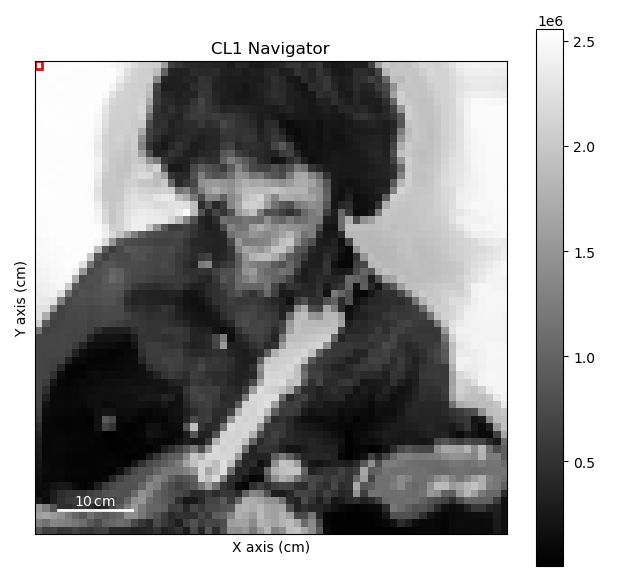

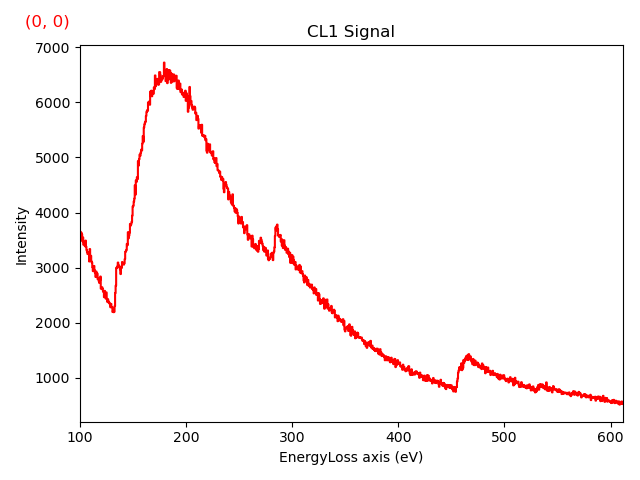

In [3]:
s.plot()

To perform SVD in HyperSpy we use the `decomposition` method that, by default, performs SVD.

In [4]:
s.decomposition()

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None


The result of the decomposition is stored in the `learning_results` attribute.

In [6]:
s

Decomposition parameters
------------------------
normalize_poissonian_noise=False
algorithm=SVD
output_dimension=None
centre=None


SVD decomposes the data in so-called "components" and sorts them in order of decreasing relevance. It is often useful to estimate the dimensionality of the data by plotting the explained variance against the component index on a logarithmic y-scale. This plot is sometimes called a scree-plot and it should drop quickly, eventually becoming a slowly descending line. The point at which it becomes linear is often a good estimation of the dimensionality of the data (or equivalently, the number of components that should be retained).

To plot the scree plot, run the `plot_explained_variance_ratio` method e.g.:


<Axes: title={'center': '\nPCA Scree Plot'}, xlabel='Principal component index', ylabel='Proportion of variance'>

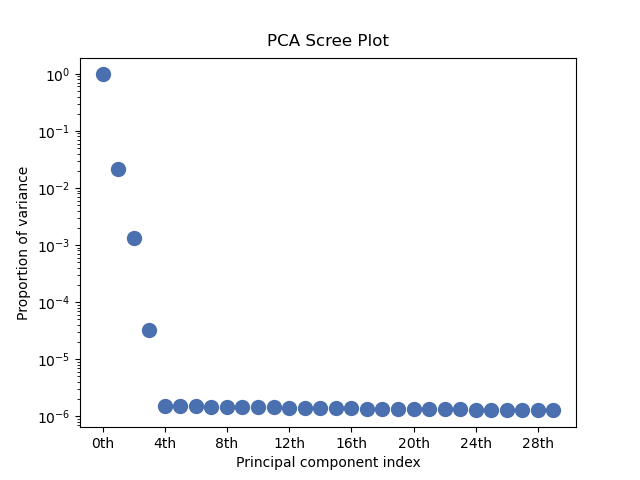

In [7]:
s.plot_explained_variance_ratio()

From the scree plot we estimate that there are 4 principal components.

We can store the scree plot as a `Spectrum` instance using the following method:

In [8]:
scree_plot = s.get_explained_variance_ratio()

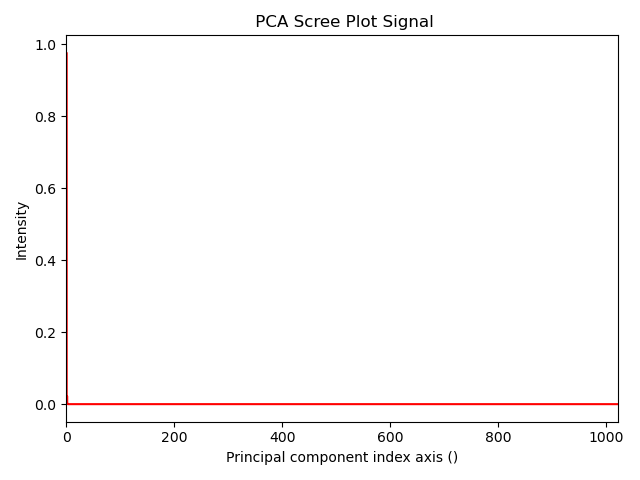

In [9]:
scree_plot.plot()

### Shot noise

PCA assumes gaussian noise, however, the noise in EELS spectra is approximately poissonian (shot noise). It is possible to approximately "normalise" the noise by using a liner transformation, which should result in a better decomposition of data with shot noise. This is done in HyperSpy as follows:

In [10]:
s.decomposition(normalize_poissonian_noise=True)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


Let's plot the scree plot of this and the previous decomposition in the same figure

<Axes: title={'center': '\nPCA Scree Plot'}, xlabel='Principal component index', ylabel='Proportion of variance'>

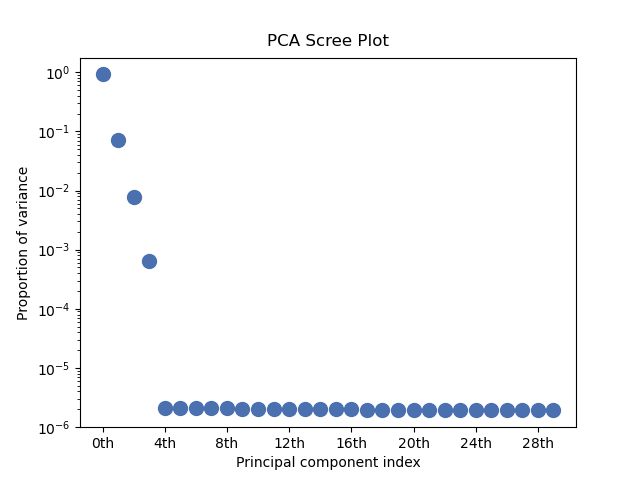

In [12]:
s.plot_explained_variance_ratio()

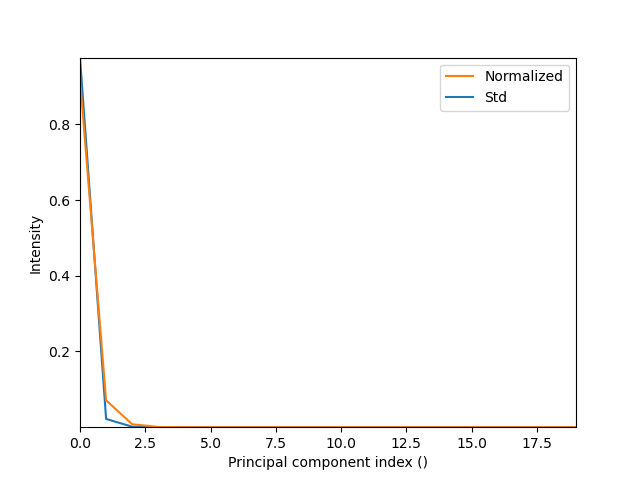

In [11]:
ax = hs.plot.plot_spectra([scree_plot.isig[:20],
                          s.get_explained_variance_ratio().isig[:20]],
                          legend=("Std", "Normalized"))

Let's improve the plot using some [matplotlib](http://matplotlib.org/) commands:

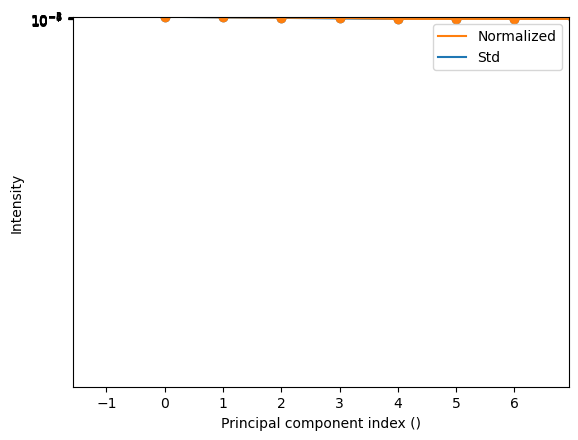

In [13]:
ax.set_yscale('log')
ax.lines[0].set_marker("o")
ax.lines[1].set_marker("o")
ax.figure #for details of how these commands work see the matplotlib webpage

As we can see, the explained variance of the first four components of the normalized decomposition are "further away" from the noise than those of the original data, indicating a better decomposition.

### Visualise the decomposition results

The following commands can be used to plot the first $n$ principal components.
(Note: the `_=` part at the beginning is for webpage rendering purposes and is not strictly needed in the command) 

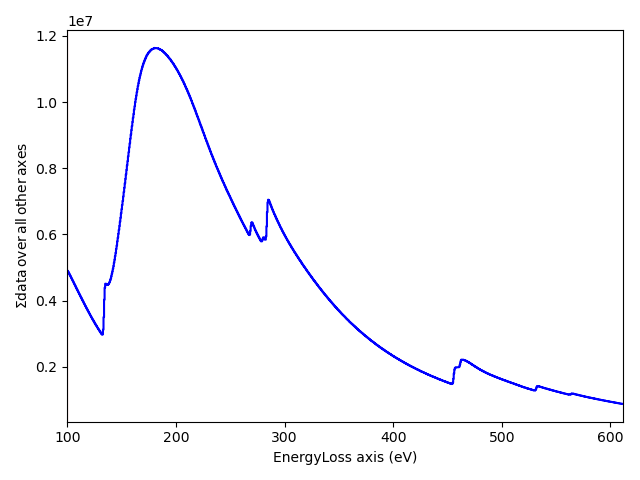

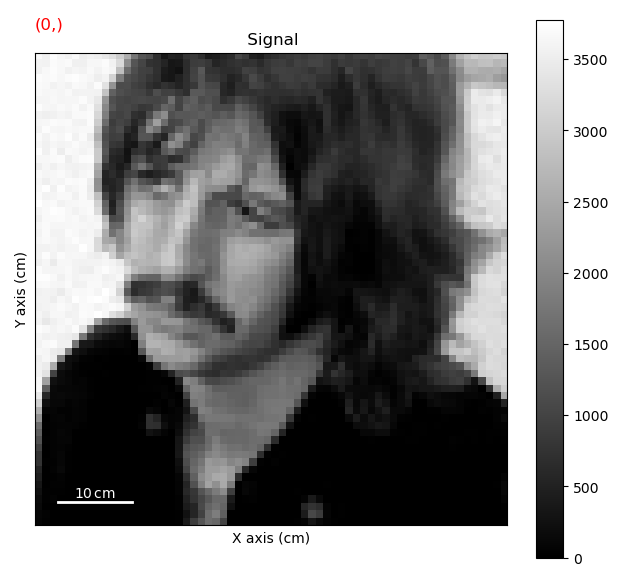

In [17]:
s.T.plot()

/home/francisco/miniforge3/lib/python3.9/site-packages/hyperspy/signal.py:2113: VisibleDeprecationWarning: The 'comp_label' argument will be deprecated in 2.0, please use 'title' instead
  warnings.warn("The 'comp_label' argument will be deprecated "


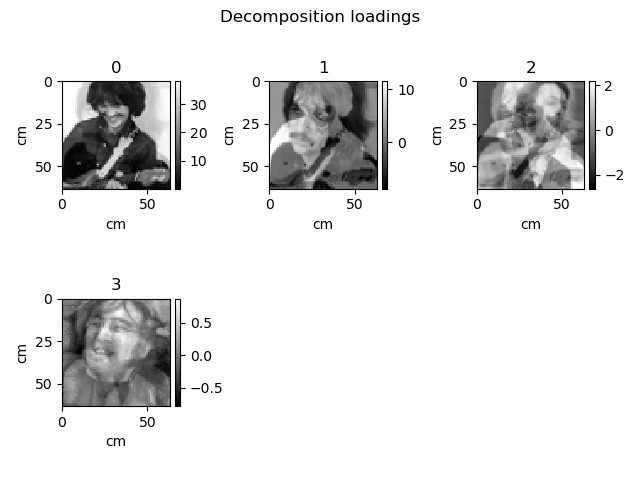

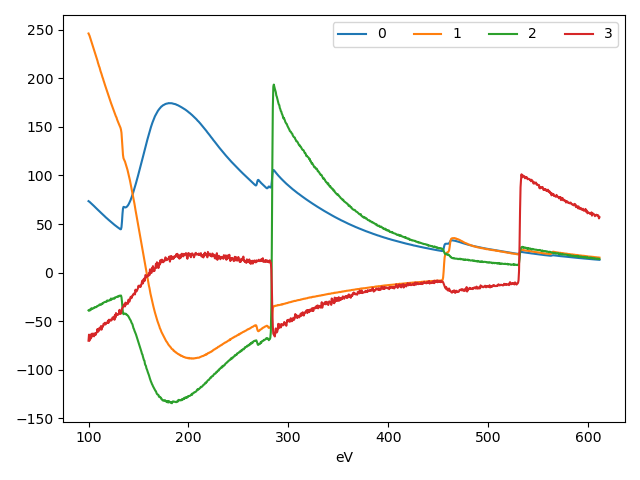

In [14]:
_ = s.plot_decomposition_loadings(4)
_ = s.plot_decomposition_factors(4, comp_label="")

Alternatively (and usually more conveniently) we can use the following plotting method. Use the slider or the left/right arrow keys to change the index of the components in interactive plotting mode. 

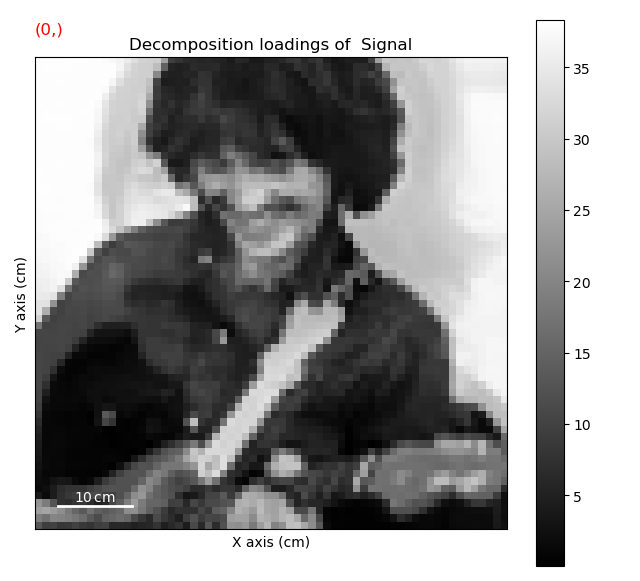

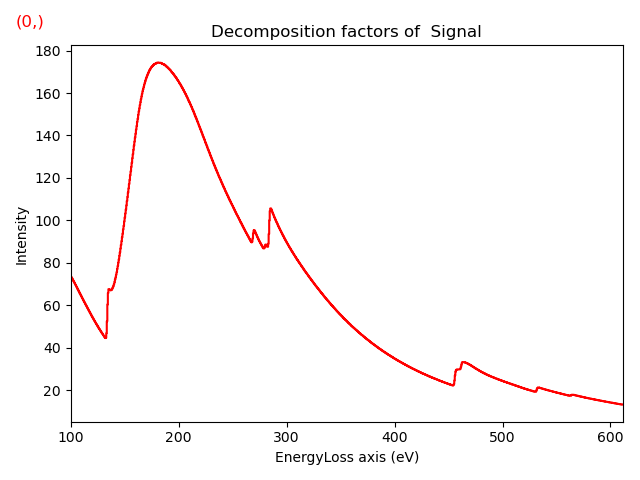

In [18]:
s.plot_decomposition_results()

### Noise reduction

A common application of PCA is noise reduction, which is achieved by dimensionality reduction. We can create a "denoised" version of the dataset by inverting the decomposition using only the number of principal components that we want to retain (in this case the first 4 components). This is done with the `get_decomposition_model` command.

In [19]:
sc = s.get_decomposition_model(4)

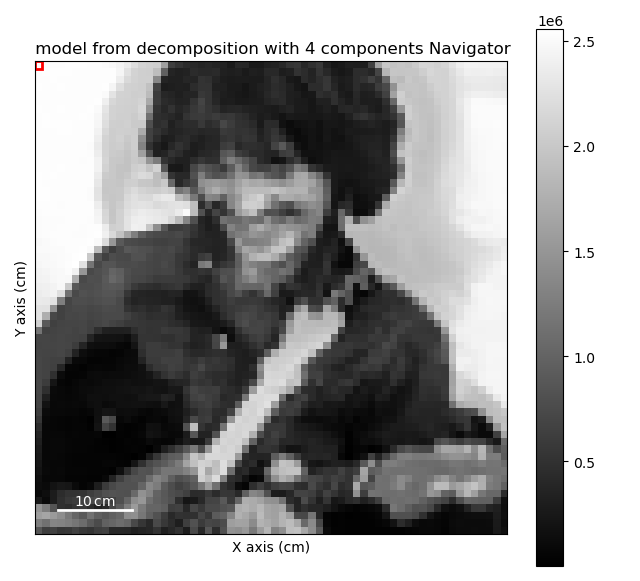

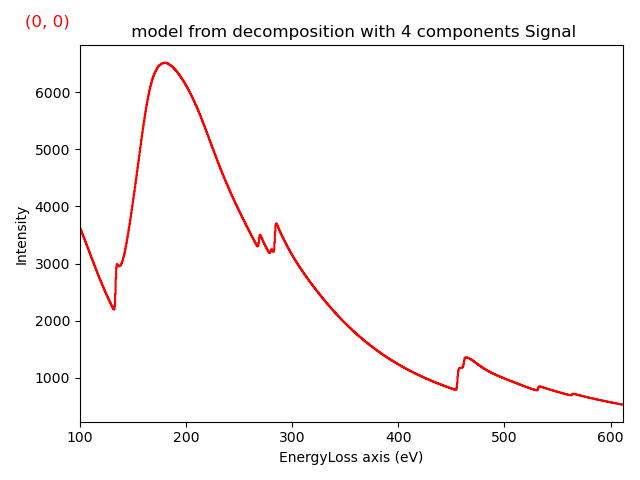

In [20]:
sc.plot()

Let's plot the spectra at coordinates (30,30) from the original and PCA-denoised datasets

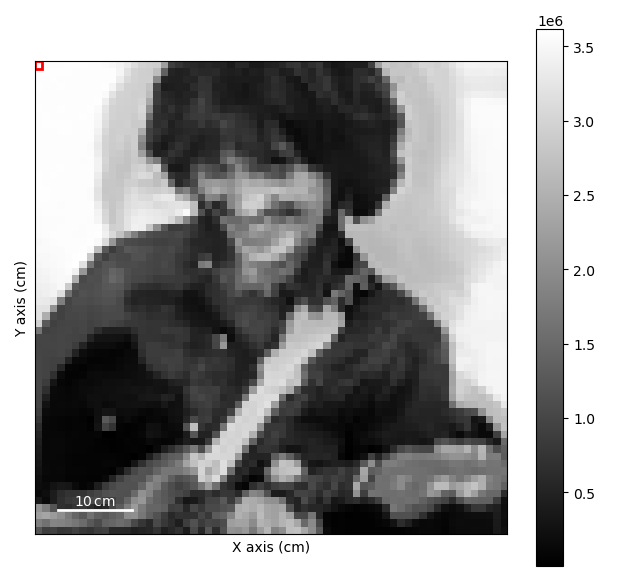

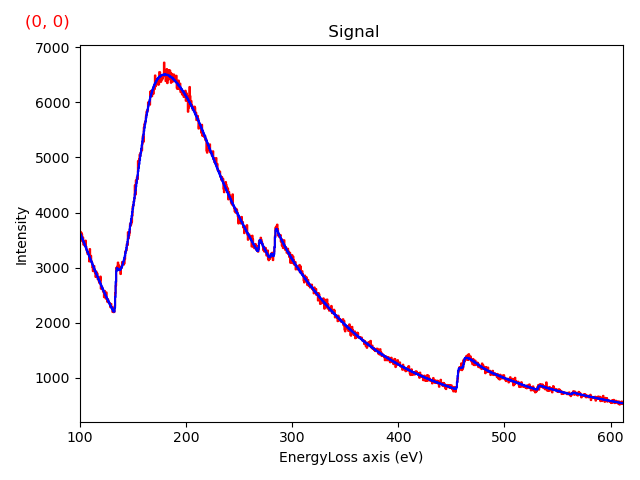

In [21]:
(s + sc * 1j).plot()

Calculating and plotting the residuals at a given position can be done in one single line

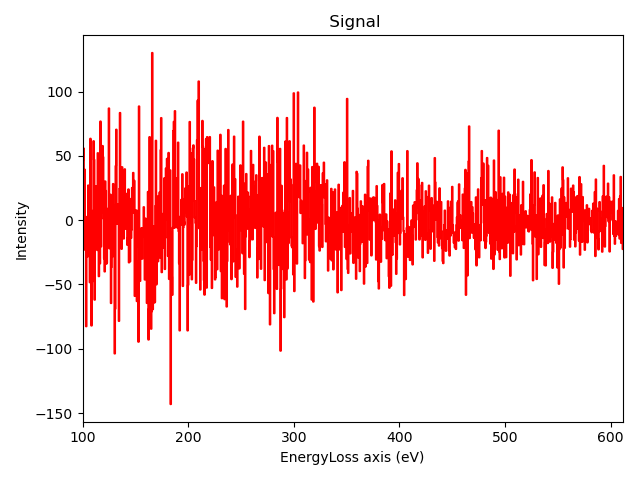

In [22]:
(s - sc).inav[30,30].plot()

## 2. Blind source separation

### Independent component analysis

As we have seen in the previous section, the principal components are a linear mixture of EELS elemental maps and spectra, but the mixing matrix is unknown. We can use blind source separation (BSS) to estimate the mixing matrix. In this case we will use independent component analysis. BSS is performed in HyperSpy using the `blind_source_separation` method that by default uses "FastICA" which is a well-tested ICA routine.

In [23]:
s.blind_source_separation(4, diff_order=1)

[########################################] | 100% Completed | 102.65 ms


Blind source separation info:
  number_of_components=4
  algorithm=sklearn_fastica
  diff_order=1
  reverse_component_criterion=factors
  whiten_method=PCA
scikit-learn estimator:
FastICA(tol=1e-10, whiten=False)


The results are also stored in the `learning_results` attribute:

In [24]:
s.learning_results.summary()

'Decomposition parameters\n------------------------\nnormalize_poissonian_noise=True\nalgorithm=SVD\noutput_dimension=None\ncentre=None\n\nDemixing parameters\n-------------------\nalgorithm=sklearn_fastica\nn_components=4'

And can be visualised with the following commands:

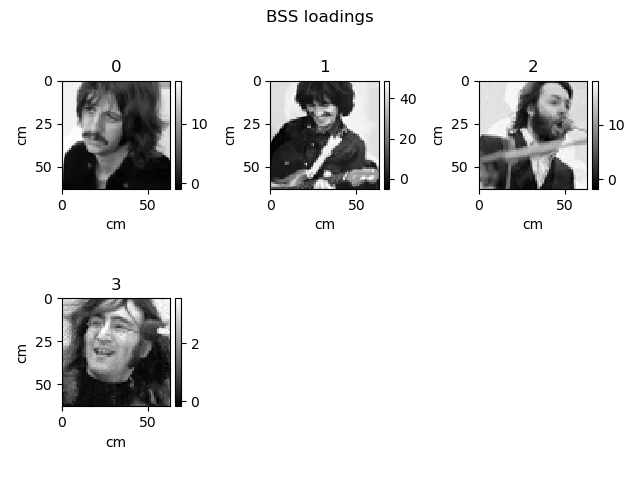

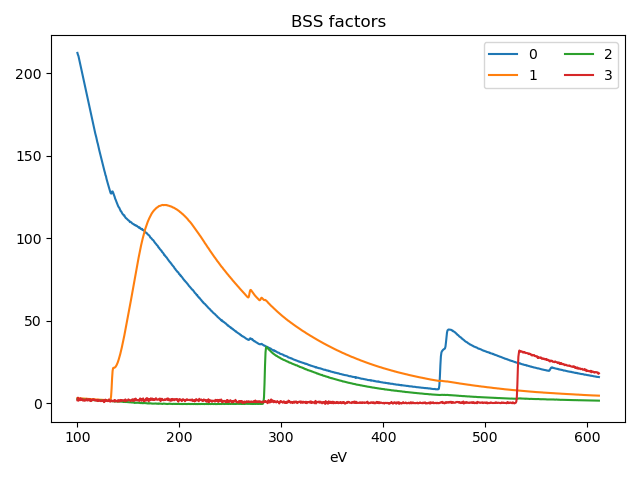

In [25]:
_ = s.plot_bss_loadings()
_ = s.plot_bss_factors()

Or usually more conveniently:

In [ ]:
s.plot_bss_results()

### Non-negative matrix factorization

By using a different matrix factorization method, non-negative matrix factorization (NMF) we can decompose the data into "elemental" components directly. NMF replaces the orthogonality constraint in SVD by a positivity constraint.

In [26]:
s.decomposition(True, algorithm="nmf", output_dimension=4)

/home/francisco/miniforge3/lib/python3.9/site-packages/hyperspy/learn/mva.py:296: VisibleDeprecationWarning: The algorithm name `nmf` has been deprecated and will be removed in HyperSpy 2.0. Please use `NMF` instead.
  warnings.warn(


Decomposition info:
  normalize_poissonian_noise=True
  algorithm=NMF
  output_dimension=4
  centre=None
scikit-learn estimator:
NMF(n_components=4)


/home/francisco/miniforge3/lib/python3.9/site-packages/hyperspy/signal.py:362: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure()


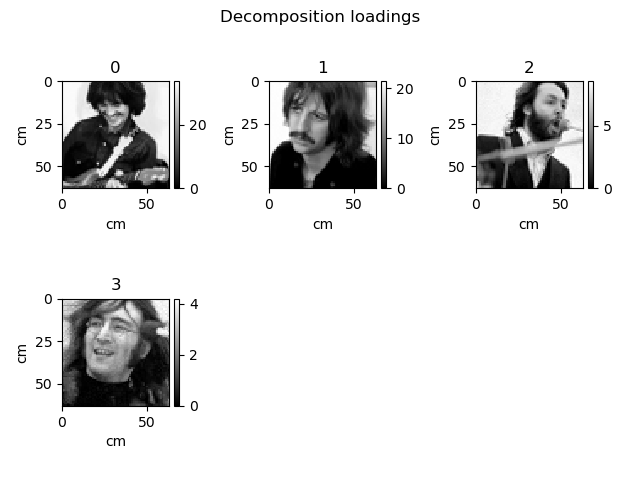

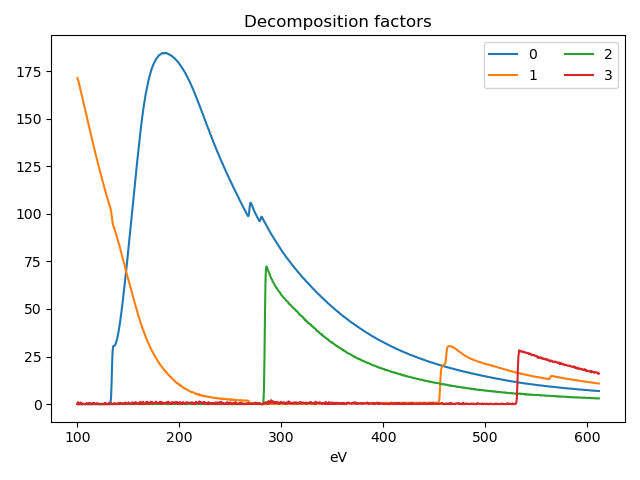

In [27]:
_ = s.plot_decomposition_loadings()
_ = s.plot_decomposition_factors()

ICA and NMF both do a good job, NMF being slightly better in this case. However, some mixing remains in both cases. In the case of ICA the main cause is noise as we will show by analysing in the same way an identical dataset with less noise.

In [ ]:
s2 = hs.load("machine_learning/CL2.hdf5")
s2.decomposition(True)
s2.blind_source_separation(4, diff_order=2)
_ = s2.plot_bss_loadings()
_ = s2.plot_bss_factors()

Note that the better SNR permits using a second numerical derivative which enhances the independence of the sources, improving the performance of ICA in this case.

In [ ]:
s2.decomposition(True, algorithm="nmf", output_dimension=4)
_ = s2.plot_decomposition_loadings()
_ = s2.plot_decomposition_factors()

For this dataset with better SNR ICA outperforms NMF

## 3. Pre-processing

EELS datasets sometime suffer from energy instability. This introduces a non-linearity in the data, resulting in a higher number of components than there are genuine spectral signatures coming from the object. As an example let's have a look at the `CL3` dataset.

In [ ]:
s3 = hs.load("machine_learning/CL3.hdf5")

In [ ]:
s3.plot()

In [ ]:
s3.decomposition(True)

In [ ]:
s3.plot_explained_variance_ratio()

The scree plot now suggests that we need more components to accurately explain this dataset.

In this case we can partially correct the energy instability using the low-loss spectrum image contained in the `LL.hdf5` file. (To do this with real data you would need the low-loss spectra simultaneously acquired, using a dual EELS camera)

In [ ]:
ll3 = hs.load("machine_learning/LL3.hdf5")

In [ ]:
ll3.plot()

In [ ]:
ll3

In [ ]:
ll3.align_zero_loss_peak(also_align=[s3])

In [ ]:
s3.decomposition(True)

In [ ]:
s3.plot_explained_variance_ratio()

The scree plot is now more similar to the scree plot of the `CL1` dataset. However the alignment is not perfect and the scree plot still shows the effect of the remaining instability in the dataset. Nevertheless, performing BSS on the first four components results in very similar components to those of `CL1`

In [ ]:
s3.blind_source_separation(4, diff_order=2)
_ = s3.plot_bss_loadings()
_ = s3.plot_bss_factors()

Another usual complication in real data are spikes. As an example, let's load the "CL4" dataset.

In [ ]:
s4 = hs.load("machine_learning/CL4.hdf5")

In [ ]:
s4.decomposition(True)

In [ ]:
s4.plot_explained_variance_ratio()

In this case the increase in the number of components required to explain the dataset is due to a high  number of spikes and the same energy instability as in the `CL3` dataset. We can remove the spikes using the `spikes_removal_tool`

In [ ]:
s4.spikes_removal_tool()

And the instability as above:

In [ ]:
ll4 = hs.load("machine_learning/LL3.hdf5")
ll4.align_zero_loss_peak(also_align=[s4])# after this, re-run the decomposition and re-plot the scree-plot using the lines above